## MNIST
In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small images of digits
handwritten by high school students and employees of the US Census Bureau. Each image is labeled with
the digit it represents. This set has been studied so much that it is often called the “Hello World” of
Machine Learning: whenever people come up with a new classification algorithm, they are curious to see
how it will perform on MNIST. Whenever someone learns Machine Learning, sooner or later they tackle
MNIST.

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:
- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one column per feature
- A target key containing an array with the labels

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape , y.shape

((70000, 784), (70000,))

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels,
and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek
at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28
array, and display it using Matplotlib’s imshow() function:

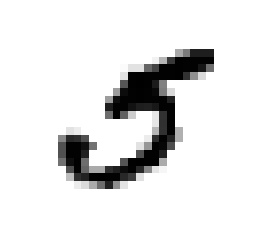

In [26]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]

some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [27]:
y[20000]

3.0

In [28]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you
don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the
order of the training instances, and they perform poorly if they get many similar instances in a row.
Shuffling the dataset ensures that this won’t happen

In [29]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier
Let’s simplify the problem for now and only try to identify one digit — for example, the number 5. This
“5-detector” will be an example of a binary classifier, capable of distinguishing between just two
classes, 5 and not-5. Let’s create the target vectors for this classification task:

In [30]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

Okay, now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent
(SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being
capable of handling very large datasets efficiently. This is in part because SGD deals with training
instances independently, one at a time (which also makes SGD well suited for online learning), as we
will see later. Let’s create an SGDClassifier and train it on the whole training set:

In [31]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you
should set the random_state parameter.

In [32]:
#Now you can use it to detect images of the number 5:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large
part of this chapter on this topic. There are many performance measures available, so grab another coffee
and get ready to learn many new concepts and acronyms!

### Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation

### IMPLEMENTING CROSS-VALIDATION
Occasionally you will need more control over the cross-validation process than what cross_val_score() and similar functions provide.
In these cases, you can implement cross-validation yourself; it is actually fairly straightforward. The following code does roughly the
same thing as the preceding cross_val_score() code, and prints the same result

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

0.96455
0.96415
0.9599


The StratifiedKFold class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio
of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on
the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

Let’s use the cross_val_score() function to evaluate your SGDClassifier model using K-fold crossvalidation,
with three folds. Remember that K-fold cross-validation means splitting the training set into
K-folds (in this case, three), then making predictions and evaluating them on each fold using a model
trained on the remaining folds

In [34]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.96455,  0.96415,  0.9599 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks
amazing, doesn’t it? Well, before you get too excited, let’s look at a very dumb classifier that just
classifies every single image in the “not-5” class:

In [36]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Can you guess this model’s accuracy? Let’s find out:

In [39]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.90875,  0.91005,  0.91015])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if
you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

*This demonstrates why accuracy is generally not the preferred performance measure for classifiers,
especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent
than others).*

### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The
general idea is to count the number of times instances of class A are classified as class B. For example, to
know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and
3rd column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to
the actual targets. You could make predictions on the test set, but let’s keep it untouched for now
(remember that you want to use the test set only at the very end of your project, once you have a classifier
that you are ready to launch). Instead, you can use the cross_val_predict() function:

In [40]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation,
but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means
that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is
made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the
target classes (y_train_5) and the predicted classes (y_train_pred):

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53886,   693],
       [ 1535,  3886]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted
class. The first row of this matrix considers non-5 images (the negative class): 53,272 of them were
correctly classified as non-5s (they are called **true negatives**), while the remaining 1,307 were wrongly
classified as 5s (**false positives**). The second row considers the images of 5s (the positive class): 1,077
were wrongly classified as non-5s (**false negatives**), while the remaining 4,344 were correctly classified
as 5s (**true positives**).

A perfect classifier would have only true positives and true negatives, so its
confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric.
An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the
classifier

### Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics, including precision and recall

In [47]:
y_train_pred.shape

(60000,)

In [48]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) 
# == 4344 / (4344 + 1307)
#0.76871350203503808
recall_score(y_train_5, y_train_pred) # == 4344 / (4344 + 1077)
#0.79136690647482011

0.7168419110865154